In [1]:
# 1. 필요한 라이브러리 및 모듈 불러오기

import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist

# matplotlib 설정 (그래프 크기 조절)
plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
# 2. 이미지 전처리 함수 정의 - Binarization 및 Skeletonization

def binarize_image(image, threshold=127):
    """
    이미지를 이진화(binarization)하는 함수
    :param image: 입력 이미지 (그레이스케일)
    :param threshold: 이진화 임계값
    :return: 이진화된 이미지
    """
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

def skeletonize_image(binary_image):
    """
    이진화된 이미지를 skeletonization하는 함수
    binary_image: 이진화된 이미지
    return: skeletonized 이미지
    """
    skeleton = skeletonize(binary_image // 255) * 255
    return skeleton.astype(np.uint8)

def preprocess_image(image_path):
    """
    이미지를 전처리(binarization 및 skeletonization)하는 함수
    image_path: 이미지 파일 경로
    return: 전처리된 이미지
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    binary_image = binarize_image(image)
    skeleton_image = skeletonize_image(binary_image)
    return skeleton_image

In [3]:
# 3. 특징 추출 함수 정의 - Minutiae 검출 (end & bif)

def detect_minutiae(skeleton_image):
    """
    skeletonized 이미지에서 minutiae(종단점과 분기점)를 검출하는 함수
    skeleton_image: skeletonized 이미지
    return: minutiae 딕셔너리 (종단점과 분기점 좌표 포함)
    """
    minutiae = {'end': [], 'bif': []}
    rows, cols = skeleton_image.shape
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if skeleton_image[i, j] == 255:
                window = skeleton_image[i-1:i+2, j-1:j+2]
                num_neighbors = np.sum(window) // 255 - 1
                
                if num_neighbors == 1:
                    minutiae['end'].append((i, j))
                elif num_neighbors == 3:
                    minutiae['bif'].append((i, j))
    
    return minutiae

In [4]:
# 4. 매칭 함수 정의 - 매칭 및 거리 계산

def match_fingerprints(minutiae1, minutiae2, threshold=20):
    """
    두 지문 이미지의 minutiae를 매칭하고 거리 계산
    minutiae1: 첫 번째 이미지의 minutiae
    minutiae2: 두 번째 이미지의 minutiae
    threshold: 매칭 임계값
    return: matching_score (거리의 평균)
    """
    if not minutiae1['end'] or not minutiae2['end']:
        return float('inf')
    
    end1, end2 = np.array(minutiae1['end']), np.array(minutiae2['end'])
    distances = cdist(end1, end2)
    min_distances = np.min(distances, axis=1)
    matching_score = np.mean(min_distances[min_distances < threshold])
    
    return matching_score if not np.isnan(matching_score) else float('inf')

In [5]:
# 5. 메트릭 계산 함수 정의

def calculate_metrics(matches, total_pairs, threshold):
    """
    매칭 결과를 바탕으로 성능 지표 계산
    matches: 매칭 거리 리스트
    total_pairs: 총 매칭 쌍 수
    threshold: 매칭 임계값
    return: 성능 지표 딕셔너리
    """
    true_positive = np.sum(matches < threshold)
    false_negative = np.sum(matches >= threshold)
    false_positive = total_pairs - true_positive
    true_negative = 0  # 이 문맥에서는 true negative가 없음
    
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    far = false_positive / total_pairs
    frr = false_negative / total_pairs
    acc = true_positive / total_pairs
    
    return {
        'precision': precision,
        'recall': recall,
        'FAR': far,
        'FRR': frr,
        'ACC': acc
    }

In [8]:
# 6. 지문 데이터 처리 및 매칭 수행

# 데이터셋 디렉토리 설정
train_dir = './train/train_ref'
test_dir = './test2'

# 이미지 파일 리스트 가져오기
train_images = [f for f in os.listdir(train_dir) if f.endswith('.BMP')]
test_images = [f for f in os.listdir(test_dir) if f.endswith('.BMP')]

train_data = {}
test_data = {}

# Train 이미지 전처리 및 minutiae 추출
for img_name in tqdm(train_images):
    img_path = os.path.join(train_dir, img_name)
    img_id = int(img_name.split('.')[0])
    preprocessed_image = preprocess_image(img_path)
    minutiae = detect_minutiae(preprocessed_image)
    train_data[img_id] = minutiae

# Test 이미지 전처리 및 minutiae 추출
for img_name in tqdm(test_images):
    img_path = os.path.join(test_dir, img_name)
    img_id = int(img_name.split('_')[0])
    img_type = img_name.split('_')[1].split('.')[0]
    preprocessed_image = preprocess_image(img_path)
    minutiae = detect_minutiae(preprocessed_image)
    if img_id not in test_data:
        test_data[img_id] = {}
    test_data[img_id][img_type] = minutiae

# 매칭 및 메트릭 계산
matches = []
total_pairs = len(test_images)
initial_threshold = 20  # 초기 매칭 임계값 설정

for img_id in test_data:
    for img_type in test_data[img_id]:
        test_minutiae = test_data[img_id][img_type]
        if img_id in train_data:
            train_minutiae = train_data[img_id]
            distance = match_fingerprints(train_minutiae, test_minutiae, initial_threshold)
            matches.append(distance)
        else:
            matches.append(float('inf'))



  0%|          | 0/477 [00:00<?, ?it/s]

  0%|          | 0/1428 [00:00<?, ?it/s]

Threshold: 0, Metrics: {'precision': 0.0, 'recall': 0.0, 'FAR': 1.0, 'FRR': 1.0, 'ACC': 0.0}
Threshold: 1, Metrics: {'precision': 0.6337535014005602, 'recall': 0.6337535014005602, 'FAR': 0.36624649859943975, 'FRR': 0.36624649859943975, 'ACC': 0.6337535014005602}
Threshold: 2, Metrics: {'precision': 0.8711484593837535, 'recall': 0.8711484593837535, 'FAR': 0.12885154061624648, 'FRR': 0.12885154061624648, 'ACC': 0.8711484593837535}
Threshold: 3, Metrics: {'precision': 0.9593837535014006, 'recall': 0.9593837535014006, 'FAR': 0.04061624649859944, 'FRR': 0.04061624649859944, 'ACC': 0.9593837535014006}
Threshold: 4, Metrics: {'precision': 0.9908963585434174, 'recall': 0.9908963585434174, 'FAR': 0.009103641456582634, 'FRR': 0.009103641456582634, 'ACC': 0.9908963585434174}
Threshold: 5, Metrics: {'precision': 0.9971988795518207, 'recall': 0.9971988795518207, 'FAR': 0.0028011204481792717, 'FRR': 0.0028011204481792717, 'ACC': 0.9971988795518207}
Threshold: 6, Metrics: {'precision': 1.0, 'recall':

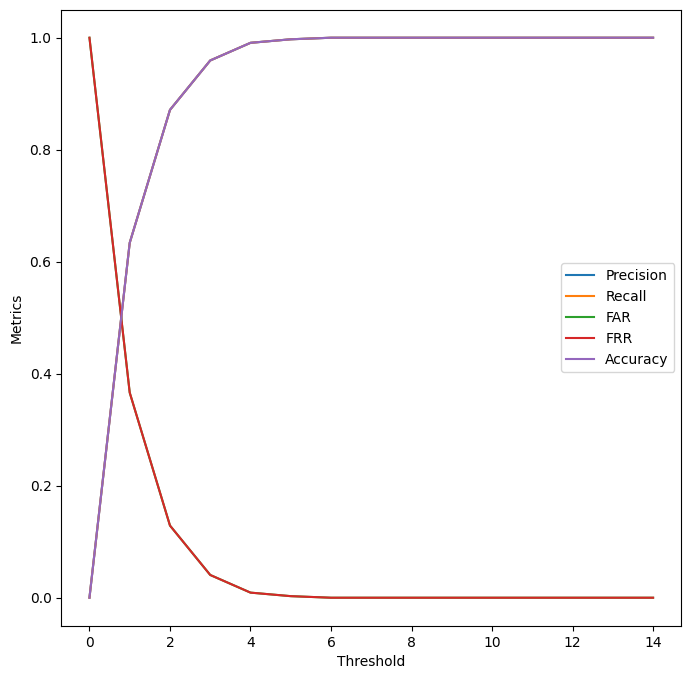

Optimal Threshold: 6
Optimal Metrics: {'precision': 1.0, 'recall': 1.0, 'FAR': 0.0, 'FRR': 0.0, 'ACC': 1.0}


In [11]:
# 7. 성능 시각화 - 최적의 threshold 찾기

def evaluate_thresholds(matches, total_pairs, thresholds):
    """
    다양한 threshold 값에 대해 성능 지표를 계산하는 함수
    matches: 매칭 거리 리스트
    total_pairs: 총 매칭 쌍 수
    thresholds: 평가할 threshold 값 리스트
    return: 각 threshold에 대한 성능 지표 리스트
    """
    results = []
    for threshold in thresholds:
        metrics = calculate_metrics(matches, total_pairs, threshold)
        results.append((threshold, metrics))
    return results

# 적절한 threshold 설정을 위한 성능 평가
thresholds = np.arange(0, 15, 1)
results = evaluate_thresholds(np.array(matches), total_pairs, thresholds)

# 성능 지표 출력 및 시각화
for threshold, metrics in results:
    print(f"Threshold: {threshold}, Metrics: {metrics}")

# 성능 지표 시각화
precisions = [metrics['precision'] for _, metrics in results]
recalls = [metrics['recall'] for _, metrics in results]
fars = [metrics['FAR'] for _, metrics in results]
frrs = [metrics['FRR'] for _, metrics in results]
accs = [metrics['ACC'] for _, metrics in results]

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, fars, label='FAR')
plt.plot(thresholds, frrs, label='FRR')
plt.plot(thresholds, accs, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.legend()
plt.show()

# 최적 threshold 선택
optimal_threshold = thresholds[np.argmax(accs)]
print(f"Optimal Threshold: {optimal_threshold}")

# 최적 threshold에서의 성능 지표 출력
optimal_metrics = calculate_metrics(np.array(matches), total_pairs, optimal_threshold)
print(f"Optimal Metrics: {optimal_metrics}")